# Toy Induction (attn-only-2l)

Reproduce martingale drift (order sensitivity) in a minimal circuit where induction heads can exist, and show that ablating those heads collapses the drift toward an order-invariant counting baseline.

In [180]:
# Make repo imports work regardless of where you run this from
from pathlib import Path
import sys

cwd = Path.cwd().resolve()
repo_candidates = [cwd, cwd.parent]
repo_root = next((p for p in repo_candidates if (p / 'bayesian_llm').exists()), None)
if repo_root is None:
    raise RuntimeError(f'Could not find repo root from cwd={cwd}.')

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print('Repo root:', repo_root)


Repo root: /Users/wjz/Documents/Projects/bayesian-llm


In [181]:
# Load attn-only-2l (TransformerLens)
import torch
import numpy as np
import pandas as pd

from transformer_lens import HookedTransformer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float32 if DEVICE == 'cpu' else torch.float16

model = HookedTransformer.from_pretrained('attn-only-2l', device=DEVICE, dtype=DTYPE)
print('Loaded attn-only-2l')
print('device:', DEVICE, 'dtype:', DTYPE)
print('n_layers:', model.cfg.n_layers, 'n_heads:', model.cfg.n_heads, 'd_model:', model.cfg.d_model)


Loaded pretrained model attn-only-2l into HookedTransformer
Loaded attn-only-2l
device: cpu dtype: torch.float32
n_layers: 2 n_heads: 8 d_model: 512


In [182]:
# Define the stimuli and verify tokenization (important!)

# We predict between exactly two single-token candidates: " X" and " Y"
X_STR = ' X'
Y_STR = ' Y'

X_ID = model.to_single_token(X_STR)
Y_ID = model.to_single_token(Y_STR)

print('X_STR token id:', X_ID)
print('Y_STR token id:', Y_ID)

# Sanity: decode
print('decode X:', repr(model.tokenizer.decode([X_ID])))
print('decode Y:', repr(model.tokenizer.decode([Y_ID])))


X_STR token id: 1558
Y_STR token id: 712
decode X: ' X'
decode Y: ' Y'


In [183]:
# Construct sequences with identical counts but different order

# All have 3 X and 3 Y. If the model were a perfect count-based Bayesian updater, predictions should match.
SEQUENCES = {
    'patterned': ['X','Y','X','Y','X','Y'],
    'clumped':   ['X','X','X','Y','Y','Y'],
    'mixed':     ['X','Y','Y','X','X','Y'],
}

def counts(seq):
    n_x = sum(t == 'X' for t in seq)
    n_y = sum(t == 'Y' for t in seq)
    return n_x, n_y

for name, seq in SEQUENCES.items():
    print(name, seq, 'counts=', counts(seq))


patterned ['X', 'Y', 'X', 'Y', 'X', 'Y'] counts= (3, 3)
clumped ['X', 'X', 'X', 'Y', 'Y', 'Y'] counts= (3, 3)
mixed ['X', 'Y', 'Y', 'X', 'X', 'Y'] counts= (3, 3)


In [184]:
# Order-invariant baselines: Frequentist and Bayesian (Beta-Bernoulli)

# Frequentist: p_hat = n_X / (n_X + n_Y)
# Bayesian posterior predictive: Beta(alpha,beta) prior -> (alpha+n_X)/(alpha+beta+n)

ALPHA = 1.0
BETA = 1.0

def frequentist_p_x(n_x, n_y):
    n = n_x + n_y
    return n_x / n if n > 0 else 0.5

def bayes_p_x(n_x, n_y, *, alpha=ALPHA, beta=BETA):
    n = n_x + n_y
    return (alpha + n_x) / (alpha + beta + n)

# These should be identical across sequences (same counts).
for name, seq in SEQUENCES.items():
    n_x, n_y = counts(seq)
    print(name, 'freq=', round(frequentist_p_x(n_x,n_y),4), 'bayes=', round(bayes_p_x(n_x,n_y),4))


patterned freq= 0.5 bayes= 0.5
clumped freq= 0.5 bayes= 0.5
mixed freq= 0.5 bayes= 0.5


In [185]:
# Model prediction utilities: logits/probs for next token

import torch

def make_prompt(seq_tokens):
    # Force each token to be preceded by a space by using "Sequence: " prefix.
    return 'Sequence: ' + ' '.join(seq_tokens)

@torch.no_grad()
def model_p_x(prompt: str):
    # Returns normalized P(X | {X,Y}), plus raw logits and softmax probs for the two tokens.
    logits = model(prompt)  # [batch=1, pos, vocab]
    last = logits[0, -1, :]

    logit_x = float(last[X_ID].item())
    logit_y = float(last[Y_ID].item())

    probs = torch.softmax(last.float(), dim=-1)
    p_x = float(probs[X_ID].item())
    p_y = float(probs[Y_ID].item())

    norm = p_x + p_y
    p_x_norm = p_x / norm if norm > 0 else 0.5
    p_y_norm = p_y / norm if norm > 0 else 0.5

    return {
        'logit_X': logit_x,
        'logit_Y': logit_y,
        'logit_diff_XminusY': logit_x - logit_y,
        'p_X_raw': p_x,
        'p_Y_raw': p_y,
        'p_X_norm': p_x_norm,
        'p_Y_norm': p_y_norm,
    }

# Quick smoke test
print(model_p_x(make_prompt(SEQUENCES['patterned'])))


{'logit_X': 16.456562042236328, 'logit_Y': 16.688007354736328, 'logit_diff_XminusY': -0.2314453125, 'p_X_raw': 0.3630204200744629, 'p_Y_raw': 0.4575583338737488, 'p_X_norm': 0.44239558766028425, 'p_Y_norm': 0.5576044123397158}


In [186]:
# Baseline: evaluate patterned/clumped/mixed and compute drift

rows = []
for name, seq in SEQUENCES.items():
    n_x, n_y = counts(seq)
    prompt = make_prompt(seq)
    out = model_p_x(prompt)

    rows.append({
        'name': name,
        'seq': ' '.join(seq),
        'n_X': n_x,
        'n_Y': n_y,
        'freq_p_X': frequentist_p_x(n_x,n_y),
        'bayes_p_X': bayes_p_x(n_x,n_y),
        **out,
    })

df = pd.DataFrame(rows).sort_values('name')
display(df)

drift = float(df.p_X_norm.max() - df.p_X_norm.min())
print('Drift (max-min) over permutations with same counts:', drift)


,name,seq,n_X,n_Y,freq_p_X,bayes_p_X,logit_X,logit_Y,logit_diff_XminusY,p_X_raw,p_Y_raw,p_X_norm,p_Y_norm
1,clumped,X X X Y Y Y,3,3,0.5,0.5,13.711938,16.499058,-2.787120,0.046048,0.747545,0.058024,0.941976
2,mixed,X Y Y X X Y,3,3,0.5,0.5,16.303320,17.032228,-0.728909,0.273409,0.566727,0.325434,0.674566
0,patterned,X Y X Y X Y,3,3,0.5,0.5,16.456562,16.688007,-0.231445,0.363020,0.457558,0.442396,0.557604


Drift (max-min) over permutations with same counts: 0.3843714126015948


## Visualize Attention with CircuitVis

We visualize attention patterns for both layers. Induction heads typically show a distinctive pattern where they attend to positions that enable copying of the next token after a previous occurrence of the same context token.


In [187]:
# Run with cache and visualize attention patterns for each sequence

import pkgutil
from IPython.display import display
import circuitsvis as cv

for name, seq in SEQUENCES.items():
    prompt = make_prompt(seq)
    logits, cache = model.run_with_cache(prompt)
    tokens = model.to_str_tokens(prompt)

    print('===', name, '===')
    print('Tokens:', tokens)

    for layer in range(model.cfg.n_layers):
        # cache['pattern', layer] has shape [batch, head, query, key]
        patt = cache['pattern', layer][0].detach().cpu().numpy()
        display(cv.attention.attention_patterns(tokens=tokens, attention=patt))


=== patterned ===
Tokens: ['<|BOS|>', 'Sequence', ':', ' X', ' Y', ' X', ' Y', ' X', ' Y']


=== clumped ===
Tokens: ['<|BOS|>', 'Sequence', ':', ' X', ' X', ' X', ' Y', ' Y', ' Y']


=== mixed ===
Tokens: ['<|BOS|>', 'Sequence', ':', ' X', ' Y', ' Y', ' X', ' X', ' Y']


## Identify Induction Heads

We remove heads that if ablated would reduce drift the most?

Metric: drift = max(P(X|{X,Y})) - min(P(X|{X,Y})) across the three sequences.


In [188]:
# Ablation utilities

from transformer_lens.utils import get_act_name

def ablate_heads(heads):
    # heads: list of (layer, head)
    # Hook on z so the head contributes ~0 to residual stream.
    layer_to_heads = {}
    for layer, head in heads:
        layer_to_heads.setdefault(int(layer), []).append(int(head))

    hooks = []
    for layer, hs in layer_to_heads.items():
        hs = sorted(set(hs))
        hook_name = get_act_name('z', layer)

        def hook_fn(z, hook, hs=hs):
            z[:, :, hs, :] = 0.0
            return z

        hooks.append((hook_name, hook_fn))
    return hooks

@torch.no_grad()
def eval_sequences(fwd_hooks=None):
    rows = []
    for name, seq in SEQUENCES.items():
        n_x, n_y = counts(seq)
        prompt = make_prompt(seq)
        logits = model(prompt) if fwd_hooks is None else model.run_with_hooks(prompt, fwd_hooks=fwd_hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        p_x = float(probs[X_ID].item())
        p_y = float(probs[Y_ID].item())
        p_x_norm = p_x / (p_x + p_y) if (p_x + p_y) > 0 else 0.5

        rows.append({
            'name': name,
            'p_X_norm': p_x_norm,
            'logit_diff_XminusY': float(last[X_ID].item() - last[Y_ID].item()),
            'bayes_p_X': bayes_p_x(n_x,n_y),
            'freq_p_X': frequentist_p_x(n_x,n_y),
        })
    df = pd.DataFrame(rows)
    drift = float(df.p_X_norm.max() - df.p_X_norm.min())
    mae_to_bayes = float((df.p_X_norm - df.bayes_p_X).abs().mean())
    return df.sort_values('name'), drift, mae_to_bayes

base_df, base_drift, base_mae = eval_sequences()
print('Baseline drift:', base_drift)
print('Baseline MAE to Bayes:', base_mae)
display(base_df)


Baseline drift: 0.3843714126015948
Baseline MAE to Bayes: 0.22471531945879306


,name,p_X_norm,logit_diff_XminusY,bayes_p_X,freq_p_X
1,clumped,0.058024,-2.787120,0.5,0.5
2,mixed,0.325434,-0.728909,0.5,0.5
0,patterned,0.442396,-0.231445,0.5,0.5


In [189]:
# Single-head ablation sweep: which head kills drift?

results = []
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        hooks = ablate_heads([(layer, head)])
        _, drift, mae = eval_sequences(fwd_hooks=hooks)
        results.append({
            'layer': layer,
            'head': head,
            'drift': drift,
            'mae_to_bayes': mae,
            'drift_reduction': base_drift - drift,
        })

df_sweep = pd.DataFrame(results).sort_values('drift_reduction', ascending=False)
display(df_sweep.head(10))

best = df_sweep.iloc[0].to_dict()
print('Top drift-reducing head:', best)


,layer,head,drift,mae_to_bayes,drift_reduction
14,1,6,0.032378,0.100424,0.351993
3,0,3,0.034538,0.020780,0.349834
5,0,5,0.162462,0.366887,0.221909
0,0,0,0.197971,0.118739,0.186401
15,1,7,0.198356,0.383296,0.186015
6,0,6,0.285915,0.213857,0.098456
9,1,1,0.349467,0.264507,0.034905
12,1,4,0.386337,0.228776,-0.001966
13,1,5,0.410252,0.196235,-0.025881
10,1,2,0.422520,0.196787,-0.038149


Top drift-reducing head: {'layer': 1.0, 'head': 6.0, 'drift': 0.03237811690966341, 'mae_to_bayes': 0.10042359962198359, 'drift_reduction': 0.3519932956919314}


In [190]:
# Choose induction-head candidates and re-test

TOPK = 2  # increase if drift remains
candidates = [(int(r.layer), int(r.head)) for r in df_sweep.head(TOPK).itertuples()]
print('Ablating candidates:', candidates)

hooks = ablate_heads(candidates)
abl_df, abl_drift, abl_mae = eval_sequences(fwd_hooks=hooks)
print('After ablation drift:', abl_drift, '(baseline:', base_drift, ')')
print('After ablation MAE to Bayes:', abl_mae, '(baseline:', base_mae, ')')
display(abl_df)


Ablating candidates: [(1, 6), (0, 3)]
After ablation drift: 0.006093206081033697 (baseline: 0.3843714126015948 )
After ablation MAE to Bayes: 0.1776527771829344 (baseline: 0.22471531945879306 )


,name,p_X_norm,logit_diff_XminusY,bayes_p_X,freq_p_X
1,clumped,0.674576,0.728953,0.5,0.5
2,mixed,0.677714,0.743286,0.5,0.5
0,patterned,0.680669,0.756847,0.5,0.5


In [191]:
# Visualize attention again (attention *patterns* won't change under z-ablation)

import pkgutil
from IPython.display import display

name = 'patterned'
seq = SEQUENCES[name]
prompt = make_prompt(seq)

logits, cache = model.run_with_cache(prompt)
tokens = model.to_str_tokens(prompt)

print('Candidates:', candidates)
print('Note: z-ablation changes contributions, not the attention weights themselves.')

for layer in range(model.cfg.n_layers):
    patt = cache['pattern', layer][0].detach().cpu().numpy()
    display(cv.attention.attention_patterns(tokens=tokens, attention=patt))


Candidates: [(1, 6), (0, 3)]
Note: z-ablation changes contributions, not the attention weights themselves.


Evaluate the ablated attn-only-2l on tasks in `toy_example.ipynb`
1) evidence sweep vs Bayes for the A=50% vs B=75% generator task,
2) martingale/order drift for fixed counts,
3) real-time tracking of a hidden bias.

In [192]:
# Prompt helpers + prediction wrapper

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from bayesian_llm.bayes import two_generator_posterior_predictive

PROMPT_STYLE = 'minimal'  # 'toy' | 'minimal'
N_TOTAL = 10
N_PERMUTATIONS = 10


def toy_prompt(sequence_tokens, *, control: str = 'order_irrelevant'):
    seq_str = ' '.join(sequence_tokens)
    if control == 'base':
        prefix = 'Two random generators. Generator A: 50% X. Generator B: 75% X.'
    elif control == 'independent':
        prefix = 'Two random generators. Generator A: 50% X. Generator B: 75% X. Draws are independent.'
    elif control == 'order_irrelevant':
        prefix = 'Two random generators. Generator A: 50% X. Generator B: 75% X. Draws are independent. Order does not matter.'
    else:
        raise ValueError(control)

    return f"{prefix} Sequence: {seq_str}. Predict the next output (X or Y):"


def minimal_prompt(sequence_tokens):
    return 'Sequence: ' + ' '.join(sequence_tokens) + ' Next is:'


def make_prompt(seq):
    if PROMPT_STYLE == 'toy':
        return toy_prompt(seq, control='order_irrelevant')
    if PROMPT_STYLE == 'minimal':
        return minimal_prompt(seq)
    raise ValueError('Unknown PROMPT_STYLE')


@torch.no_grad()
def p_x_for_prompt(prompt, *, fwd_hooks=None):
    logits = model(prompt) if fwd_hooks is None else model.run_with_hooks(prompt, fwd_hooks=fwd_hooks)
    last = logits[0, -1, :]
    probs = torch.softmax(last.float(), dim=-1)
    p_x = float(probs[X_ID].item())
    p_y = float(probs[Y_ID].item())
    return p_x / (p_x + p_y) if (p_x + p_y) > 0 else 0.5


# Hooks from the ablation sweep earlier in this notebook
try:
    _ = hooks
except NameError:
    hooks = None
    print('hooks not defined: run the ablation sweep above to define `hooks` and `candidates`.')

print('PROMPT_STYLE:', PROMPT_STYLE)
print('Using ablation hooks:', hooks is not None)


PROMPT_STYLE: minimal
Using ablation hooks: True


,n_X,bayes_p_X,freq_p_X,baseline_mean,baseline_std,ablated_mean,ablated_std
0,0,0.500244,0.0,0.066037,1.462847e-17,0.385922,0.000000e+00
1,1,0.500730,0.1,0.117012,8.104222e-02,0.433045,8.332364e-03
2,2,0.502178,0.2,0.203246,1.539970e-01,0.468512,9.528601e-03
3,3,0.506422,0.3,0.162780,1.157996e-01,0.499093,8.772212e-03
4,4,0.518326,0.4,0.402558,2.327475e-01,0.544171,8.494914e-03
5,5,0.547948,0.5,0.440970,2.628770e-01,0.568730,1.144881e-02
6,6,0.603965,0.6,0.463764,2.780697e-01,0.606721,1.030491e-02
7,7,0.670274,0.7,0.674586,2.726541e-01,0.644395,1.505185e-02
8,8,0.716249,0.8,0.854870,1.622480e-01,0.690634,9.195834e-03
9,9,0.737637,0.9,0.934890,1.296157e-02,0.725113,7.230865e-03


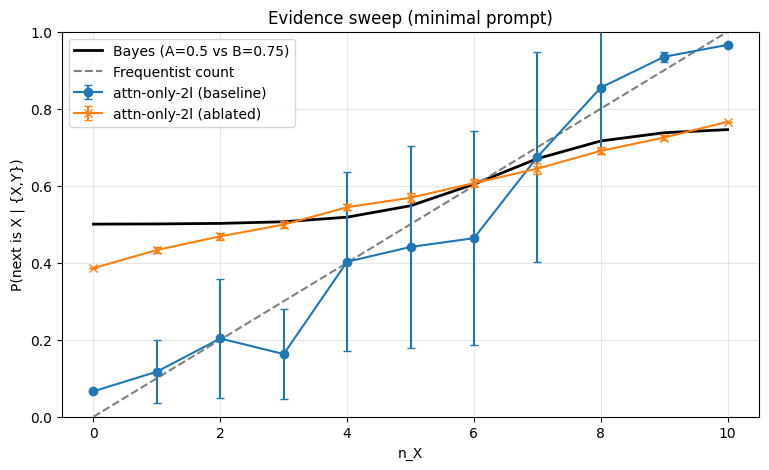

Baseline MAE to Bayes: 0.21670275644521125
Ablated MAE to Bayes: 0.03243654249125813


In [193]:
# Evidence sweep: baseline vs ablated

from bayesian_llm.data import make_sequence, permute_sequence

rows = []

rng = np.random.default_rng(0)

for n_x in range(N_TOTAL + 1):
    base_seq = make_sequence(n_x=n_x, n_total=N_TOTAL, x='X', y='Y')
    true_p = two_generator_posterior_predictive(n_x=n_x, n_total=N_TOTAL)
    freq_p = n_x / N_TOTAL if N_TOTAL > 0 else 0.5

    preds_base = []
    preds_abl = []
    for _ in range(N_PERMUTATIONS):
        seq = permute_sequence(base_seq, rng=rng)
        prompt = make_prompt(seq)
        preds_base.append(p_x_for_prompt(prompt, fwd_hooks=None))
        if hooks is not None:
            preds_abl.append(p_x_for_prompt(prompt, fwd_hooks=hooks))

    rows.append({
        'n_X': n_x,
        'bayes_p_X': true_p,
        'freq_p_X': freq_p,
        'baseline_mean': float(np.mean(preds_base)),
        'baseline_std': float(np.std(preds_base, ddof=1) if len(preds_base)>1 else 0.0),
        'ablated_mean': float(np.mean(preds_abl)) if preds_abl else None,
        'ablated_std': float(np.std(preds_abl, ddof=1) if len(preds_abl)>1 else None),
    })

df_sweep = pd.DataFrame(rows)
display(df_sweep)

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(df_sweep.n_X, df_sweep.bayes_p_X, color='black', linewidth=2, label='Bayes (A=0.5 vs B=0.75)')
ax.plot(df_sweep.n_X, df_sweep.freq_p_X, color='gray', linestyle='--', label='Frequentist count')
ax.errorbar(df_sweep.n_X, df_sweep.baseline_mean, yerr=df_sweep.baseline_std, marker='o', capsize=3, label='attn-only-2l (baseline)')
if df_sweep.ablated_mean.notna().all():
    ax.errorbar(df_sweep.n_X, df_sweep.ablated_mean, yerr=df_sweep.ablated_std, marker='x', capsize=3, label='attn-only-2l (ablated)')
ax.set_title(f'Evidence sweep ({PROMPT_STYLE} prompt)')
ax.set_xlabel('n_X')
ax.set_ylabel('P(next is X | {X,Y})')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# Summary stats
mae_base = float((df_sweep.baseline_mean - df_sweep.bayes_p_X).abs().mean())
print('Baseline MAE to Bayes:', mae_base)
if df_sweep.ablated_mean.notna().all():
    mae_abl = float((df_sweep.ablated_mean - df_sweep.bayes_p_X).abs().mean())
    print('Ablated MAE to Bayes:', mae_abl)


In [194]:
# Martingale/order drift for fixed counts

from bayesian_llm.data import permute_sequence

seq_fixed = ['X','X','X','X','Y']  # 4X/1Y
N_SAMPLES = 50

base_preds = []
abl_preds = []
for _ in range(N_SAMPLES):
    seq = permute_sequence(seq_fixed, rng=np.random.default_rng())
    prompt = make_prompt(seq)
    base_preds.append(p_x_for_prompt(prompt))
    if hooks is not None:
        abl_preds.append(p_x_for_prompt(prompt, fwd_hooks=hooks))

base_drift = float(max(base_preds) - min(base_preds))
print('Baseline drift:', base_drift)

if abl_preds:
    abl_drift = float(max(abl_preds) - min(abl_preds))
    print('Ablated drift:', abl_drift)

print('Baseline preds (first 10):', [round(x,4) for x in base_preds[:10]])
if abl_preds:
    print('Ablated preds (first 10):', [round(x,4) for x in abl_preds[:10]])


Baseline drift: 0.557145537218683
Ablated drift: 0.02350970446326972
Baseline preds (first 10): [0.8908, 0.8908, 0.8824, 0.8938, 0.8824, 0.8824, 0.8824, 0.8824, 0.8453, 0.3367]
Ablated preds (first 10): [0.6715, 0.6715, 0.6687, 0.6723, 0.6687, 0.6687, 0.6687, 0.6687, 0.6574, 0.6487]


,t,token,bayes_p_X,freq_p_X,baseline_p_X,ablated_p_X
5,6,X,0.574176,0.500000,0.193247,0.569936
6,7,X,0.596890,0.571429,0.210851,0.578374
7,8,Y,0.560089,0.500000,0.209712,0.561514
8,9,X,0.580464,0.555556,0.221188,0.580864
9,10,X,0.603965,0.600000,0.236356,0.599824


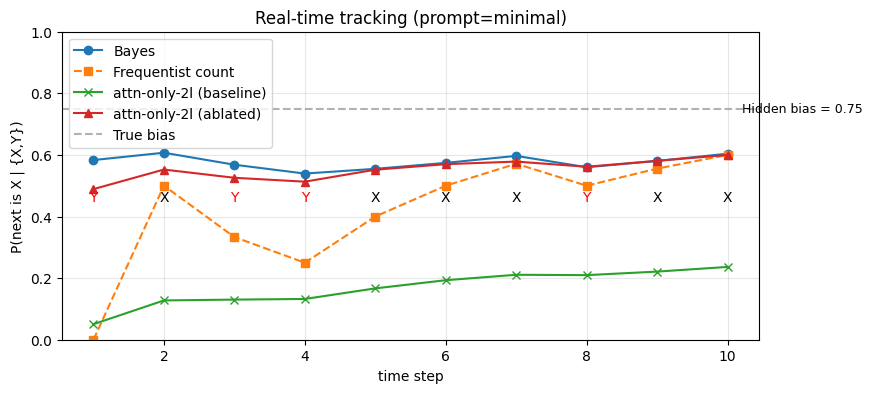

In [195]:
# Optional: real-time tracking of a hidden bias (toy_example-style)

import random

MAX_SEQ_LEN = 10
HIDDEN_BIAS = 0.75  # true generator favors X

sequence = []
rows = []

for t in range(MAX_SEQ_LEN):
    # Generate the world
    token = 'X' if random.random() < HIDDEN_BIAS else 'Y'
    sequence.append(token)

    # Bayesian predictive using two-generator task (A=0.5 vs B=0.75)
    n_x = sum(1 for x in sequence if x == 'X')
    n_total = len(sequence)
    bayes_p = two_generator_posterior_predictive(n_x=n_x, n_total=n_total)

    # Frequentist count (order-invariant)
    freq_p = n_x / n_total if n_total > 0 else 0.5

    # Model predictions
    prompt = make_prompt(sequence)
    p_base = p_x_for_prompt(prompt)
    p_abl = p_x_for_prompt(prompt, fwd_hooks=hooks) if hooks is not None else None

    rows.append({
        't': t + 1,
        'token': token,
        'bayes_p_X': bayes_p,
        'freq_p_X': freq_p,
        'baseline_p_X': p_base,
        'ablated_p_X': p_abl,
    })

track = pd.DataFrame(rows)
display(track.tail(5))

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(track.t, track.bayes_p_X, marker='o', label='Bayes')
ax.plot(track.t, track.freq_p_X, marker='s', linestyle='--', label='Frequentist count')
ax.plot(track.t, track.baseline_p_X, marker='x', label='attn-only-2l (baseline)')
if track.ablated_p_X.notna().all():
    ax.plot(track.t, track.ablated_p_X, marker='^', label='attn-only-2l (ablated)')
ax.axhline(HIDDEN_BIAS, color='gray', linestyle='--', alpha=0.6, label='True bias')

# Label hidden bias on the plot
ax.text(track.t.max() + 0.2, HIDDEN_BIAS, f'Hidden bias = {HIDDEN_BIAS:.2f}', va='center', fontsize=9)

# Annotate the generated sequence on the plot (toy_example-style)
for i, tok in enumerate(track.token):
    ax.annotate(tok, (track.t.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title(f'Real-time tracking (prompt={PROMPT_STYLE})')
ax.set_xlabel('time step')
ax.set_ylabel('P(next is X | {X,Y})')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
plt.show()


In [196]:
# Sanity check: ablation should change logits (not tied to Bayes)

seq_test = ['X','Y','X','Y','X','Y']
prompt = make_prompt(seq_test)

base = p_x_for_prompt(prompt)
abl = p_x_for_prompt(prompt, fwd_hooks=hooks) if hooks is not None else None

print('Prompt:', prompt)
print('Baseline P(X|{X,Y}):', base)
print('Ablated  P(X|{X,Y}):', abl)
print('Delta (ablated - baseline):', (abl - base) if abl is not None else None)

# Compare to Bayes/frequentist for this sequence
from bayesian_llm.bayes import two_generator_posterior_predictive

n_x = sum(1 for x in seq_test if x == 'X')
n_total = len(seq_test)
print('Bayes P(X):', two_generator_posterior_predictive(n_x=n_x, n_total=n_total))
print('Frequentist P(X):', n_x / n_total)


Prompt: Sequence: X Y X Y X Y Next is:
Baseline P(X|{X,Y}): 0.6941595489392463
Ablated  P(X|{X,Y}): 0.5830484156948076
Delta (ablated - baseline): -0.11111113324443866
Bayes P(X): 0.5741758241758241
Frequentist P(X): 0.5
